In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install segmentation-models-pytorch
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

     |████████████████████████████████| 66 kB 1.3 MB/s eta 0:00:011
     |████████████████████████████████| 58 kB 3.2 MB/s  eta 0:00:01
     |████████████████████████████████| 244 kB 11.9 MB/s eta 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=f203ae0b35e8195d581578e0305c20b8716f5f33a5c440f1ed673c6acb39a8c8
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60963 sha256=3c19de41ed53663b28014f6f5edfb65001fc9a6b3ee7e990b6014da33d246d45
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-9cfveq6n
  Running command git clone -q https://github.com/qubvel/segmentation_models.pyto

In [2]:
import os
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import matplotlib
import segmentation_models_pytorch as smp
import cv2
import pydicom as dicom
import torch
import ast # https://www.geeksforgeeks.org/python-convert-a-string-representation-of-list-into-list/
from skimage import exposure
import segmentation_models_pytorch as smp
from PIL import Image 
import glob
import math

In [3]:
os.listdir("../input/siim-covid19-detection")

['sample_submission.csv',
 'train_image_level.csv',
 'test',
 'train',
 'train_study_level.csv']

In [4]:
train_image_df = pd.read_csv('../input/siim-covid19-detection/train_image_level.csv')
train_study_df = pd.read_csv('../input/siim-covid19-detection/train_study_level.csv')


In [5]:
train_study_df.head(4)

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0


In [6]:
try:
    train_study_df['id'] = train_study_df['id'].str.replace('_study',"")
    train_study_df.rename(columns={'id': 'StudyInstanceUID'}, inplace=True)
    
except KeyError:
    print(train_study_df.head())


In [7]:
train_image_df = train_image_df.merge(train_study_df, on='StudyInstanceUID')
train_image_df.head(4)

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1


In [8]:
class_names = ['Negative for Pneumonia','Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']
study_label = "study_label"

In [9]:
try:
    train_image_df.loc[train_image_df[class_names[0]] == 1, study_label] = 'negative'
    train_image_df.loc[train_image_df[class_names[1]] == 1, study_label] = 'typical'
    train_image_df.loc[train_image_df[class_names[2]] == 1, study_label] = 'indeterminate'
    train_image_df.loc[train_image_df[class_names[3]] == 1, study_label] = 'atypical'

    train_image_df.drop(class_names, axis=1, inplace=True)
    train_image_df.head(4)
    
except KeyError:
    print(train_image_df.head(4))

In [10]:
def get_image(id): # TODO: fix files search
    path_train = '/kaggle/input/siim-covid19-detection/' + 'train/' + train_image_df.loc[id, 'StudyInstanceUID']
    last_folder_in_path = os.listdir(path_train)[0]
    path_train = path_train + '/{}/'.format(last_folder_in_path)
    img_id = train_image_df.loc[id, 'id'].replace('_image','.dcm')
    data_file = dicom.dcmread(path_train + img_id)
    img = data_file.pixel_array
    
    return img

In [11]:
train_image_label_df = train_image_df[["id", "study_label"]].copy()
train_image_label_df.head()

,id,study_label
0,000a312787f2_image,typical
1,000c3a3f293f_image,negative
2,0012ff7358bc_image,typical
3,001398f4ff4f_image,atypical
4,001bd15d1891_image,typical


In [81]:
########## RM RF ##########
import shutil
shutil.rmtree("train_images")
shutil.rmtree("train_masks")
shutil.rmtree("test_images")
shutil.rmtree("test_masks")
shutil.rmtree("validation_images")
shutil.rmtree("validation_masks")

In [12]:
os.listdir("./")

['__notebook_source__.ipynb']

In [13]:
def draw_image(id):
    figure, ax = plt.subplots(1)

    img = get_image(id)
    if (train_image_df.loc[id, 'boxes'] == train_image_df.loc[id, 'boxes']):
        boxes = ast.literal_eval(train_image_df.loc[id, 'boxes'])

        for box in boxes:
            print(boxes) 
            
            mask = cv2.rectangle(img, (int(box['x']), int(box['y'])), 
                                      (int(box['x'] + box['width']), int(box['y'] + box['height'])), 
                                      (0, 0, 255), -1)
            
            ax.imshow(img)
            ax.set_title(train_image_df.loc[id, 'study_label'].split(' ')[0])


In [14]:
def get_mask(id):
    img = get_image(id)
    y = len(img[0])
    x = len(img)
    img = np.zeros((x, y, 3), np.uint8)
    
    if (train_image_df.loc[id, 'boxes'] == train_image_df.loc[id, 'boxes']):
        boxes = ast.literal_eval(train_image_df.loc[id, 'boxes'])
        
        for box in boxes:      
            mask = cv2.rectangle(img, (int(box['x']), int(box['y'])), 
                                      (int(box['x'] + box['width']), int(box['y'] + box['height'])), 
                                      (0, 0, 255), -1)
    return img

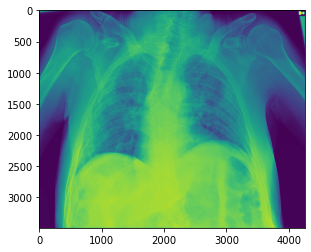

In [15]:
plt.imshow(get_image(0))

[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]
[{'x': 789.28836, 'y': 582.43035, 'width': 1026.65662, 'height': 1917.30292}, {'x': 2245.91208, 'y': 591.20528, 'width': 1094.66162, 'height': 1761.54944}]


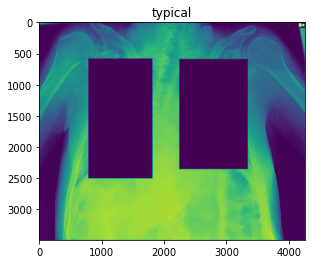

In [16]:
draw_image(0)

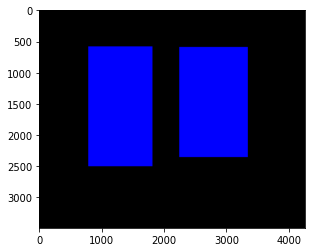

In [17]:
plt.imshow(get_mask(0))

In [18]:
!mkdir train_images
!mkdir train_masks

!mkdir test_images
!mkdir test_masks

!mkdir validation_images
!mkdir validation_masks

In [60]:
os.listdir("./")

['train_images',
 'test_images',
 'train_masks',
 'validation_masks',
 'test_masks',
 'best_model_test.pth',
 '__notebook_source__.ipynb',
 'validation_images']

In [20]:
train_image_label_df['id'] = train_image_label_df['id'].str.replace('_image', '.png')
train_image_label_df

,id,study_label
0,000a312787f2.png,typical
1,000c3a3f293f.png,negative
2,0012ff7358bc.png,typical
3,001398f4ff4f.png,atypical
4,001bd15d1891.png,typical
...,...,...
6329,ffcc6edd9445.png,negative
6330,ffd91a2c4ca0.png,negative
6331,ffd9b6cf2961.png,typical
6332,ffdc682f7680.png,typical


In [23]:
test_data = 0.2
validation_data = 0.2
samples = 10

In [24]:
stop_train = int(samples * (1 - (test_data + validation_data)))

start_test = int(stop_train)
stop_test = int(samples * (1 - validation_data))

start_val = int(stop_test)
stop_val = int(samples)

In [25]:
remove_idxs_train = []
remove_idxs_test = []
remove_idxs_val = []

def create_imgs():
    for i in range(0, stop_train):
        try:
            name = train_image_label_df.loc[i, 'id']
                    
            img = get_image(i)
            cv2.imwrite(f"./train_images/{name}", img)
            
            mask = get_mask(i)
            cv2.imwrite(f"./train_masks/{name}", mask)
            
        except (FileNotFoundError, RuntimeError) as e:
            remove_idxs_train.append(i)
            print(f"train file {name} not found at index {i}")
            pass
        
    for j in range(start_test, stop_test):
        try:
            name = train_image_label_df.loc[j, 'id']
            
            img = get_image(j)
            cv2.imwrite(f"./test_images/{name}", img)
            
            mask = get_mask(j)
            cv2.imwrite(f"./test_masks/{name}", mask)
            
        except (FileNotFoundError, RuntimeError) as e:
            remove_idxs_test.append(j)
            print(f"test file {name} not found at index {j}")
            pass
        
    for k in range(start_val, stop_val):
        try:
            name = train_image_label_df.loc[k, 'id']

            img = get_image(k)
            cv2.imwrite(f"./validation_images/{name}", img)

            mask = get_mask(k)
            cv2.imwrite(f"./validation_masks/{name}", mask)

        except (FileNotFoundError, RuntimeError) as e:
            remove_idxs_val.append(k)
            print(f"test file {name} not found at index {k}")
            pass
        
create_imgs()

In [26]:
print(len(os.listdir("./train_images")))
print(len(os.listdir("./test_images")))
print(len(os.listdir("./validation_images")))

6
2
2


In [27]:
from torch.utils.data import DataLoader
from albumentations import Resize, Normalize, Compose
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import Dataset
from torchvision.io import read_image

In [36]:
class Transform():
    def __init__(self):
        transformation = [
            Resize(256, 256),
#             Normalize(),
#             ToTensorV2(),
        ]
        self.transform = Compose(transformation)
    
    def __call__(self, image):
        transformed = self.transform(image=image)
        return transformed['image'] 

In [194]:
class SegmentationDataset(Dataset):
    def __init__(self, annotations_file, img_dir, mask_dir):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = Transform()

    def __len__(self):
        try:
            return len(self.img_labels)
        except TypeError:
            return 1        

    def __getitem__(self, idx):
            img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
            mask_path = os.path.join(self.mask_dir, self.img_labels.iloc[idx, 0])
            
            image = Image.open(img_path)
            mask = Image.open(mask_path)

            label = self.img_labels.iloc[idx, 1]

            image = np.asarray(image).astype('float32')
            image = self.transform(image=image)
            mask = np.asarray(mask).astype('float32')
            mask = self.transform(image=mask)
        
            mask = (mask / 255).astype(np.float32)
          
            image = np.stack((image, ) * 3, axis=0)
            if (mask.ndim == 3):
                mask = mask[:, :, 0]

            return image, mask

In [31]:
train_df = train_image_label_df
train_df = train_df.head(stop_train)
train_df = train_df.drop(remove_idxs_train) # TODO: fix deletion of features


test_df = train_image_label_df.iloc[start_test : stop_test]
test_df = test_df.drop(remove_idxs_test)

val_df = train_image_label_df.iloc[start_val : stop_val]
val_df = val_df.drop(remove_idxs_val)

(256, 256)


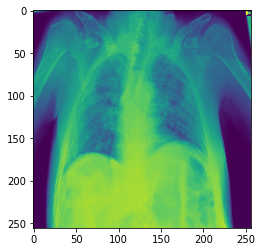

In [195]:
# FOR TESTING
train_img_dir = "./train_images"
train_mask_dir = "./train_masks"

sm = SegmentationDataset(train_df, train_img_dir, train_mask_dir)
a,c = sm.__getitem__(0)
a = a[0, :, :]
plt.imshow(a)
print(a.shape)

In [196]:
train_img_dir = "./train_images"
train_mask_dir = "./train_masks"
validation_img_dir = "./validation_images"
validation_mask_dir = "./validation_masks"

train_dataloader = DataLoader(SegmentationDataset(train_df, train_img_dir, train_mask_dir), batch_size=16, shuffle=False, num_workers=4)    
val_dataloader = DataLoader(SegmentationDataset(val_df, validation_img_dir, validation_mask_dir), batch_size=16, shuffle=False, num_workers=4)    

In [197]:
train_features, train_masks = next(iter(train_dataloader))

In [198]:
print(f"Feature batch shape: {train_features.size()}")
print(f"Masks batch shape: {train_masks.size()}")

Feature batch shape: torch.Size([6, 3, 256, 256])
Masks batch shape: torch.Size([6, 256, 256])


torch.Size([3, 256, 256])
torch.Size([256, 256])


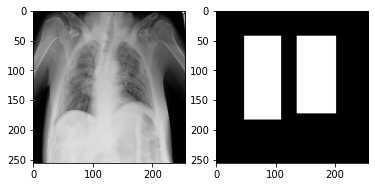

In [199]:
index = 0
fig, ax = plt.subplots(1, 2)

img = train_features[index].squeeze()
mask = train_masks[index].squeeze()

print(img.shape)
print(mask.shape)

img = img[0, :, :]
ax[0].imshow(img, cmap="gray");
ax[1].imshow(mask, cmap="gray");



In [200]:
ENCODER = "resnet34"
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
#     classes=1, 
    activation=ACTIVATION,
)

preprocess_func = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [201]:
trainmodel = True
epochs = 20
# loss = smp.utils.losses.JaccardLoss()
loss = smp.utils.losses.DiceLoss()
metrics = [ 
    smp.utils.metrics.IoU(threshold=0.5), 
]
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.001)])
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2)

trainepoch = smp.utils.train.TrainEpoch(model, 
                                        loss=loss, 
                                        optimizer=optimizer, 
                                        metrics=metrics, 
                                        verbose=True)

validepoch = smp.utils.train.ValidEpoch(model, 
                                        loss=loss, 
                                        metrics=metrics, 
                                        verbose=True)

In [202]:
!rm -rf best_model_test.pth

In [203]:
best_iou_score = - math.inf
train_logs_list, valid_logs_list = [], []

for i in range(epochs):
    print(f'\nEpoch: {i}')
    trainlogs = trainepoch.run(train_dataloader)
    validlogs = validepoch.run(val_dataloader)
    lr_scheduler.step()

    train_logs_list.append(trainlogs)
    valid_logs_list.append(validlogs)
    
    if best_iou_score < validlogs['iou_score']:
        best_iou_score = validlogs['iou_score']
        torch.save(model, './best_model_test.pth')


Epoch: 0
valid: 100%|██████████| 1/1 [00:01<00:00,  1.72s/it, dice_loss - 0.473, iou_score - 0.404]

Epoch: 1
valid: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it, dice_loss - 0.4668, iou_score - 0.5451]

Epoch: 2
valid: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it, dice_loss - 0.4443, iou_score - 0.5555]

Epoch: 3
valid: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it, dice_loss - 0.3838, iou_score - 0.519]

Epoch: 4
valid: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it, dice_loss - 0.3905, iou_score - 0.5842]

Epoch: 5
valid: 100%|██████████| 1/1 [00:01<00:00,  1.54s/it, dice_loss - 0.3012, iou_score - 0.6537]

Epoch: 6
valid: 100%|██████████| 1/1 [00:01<00:00,  1.52s/it, dice_loss - 0.2997, iou_score - 0.6238]

Epoch: 7
valid: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it, dice_loss - 0.4103, iou_score - 0.3885]

Epoch: 8
valid: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it, dice_loss - 0.4697, iou_score - 0.3619]

Epoch: 9
valid: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it, dice_loss - 0

In [204]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
dice_loss,-0.127590,-0.30394,-0.461050,-0.541522,-0.716076,-0.818741,-0.906227,-0.963486,-1.004376,-1.039453,-1.065584,-1.086371,-1.103350,-1.116826,-1.127885,-1.136256,-1.142195,-1.146187,-1.148568,-1.149685
iou_score,1.340821,3.33832,13.320737,63.947083,-18.097353,-11.755418,-7.685678,-6.099693,-5.420732,-5.028232,-4.808880,-4.654405,-4.527068,-4.441690,-4.390426,-4.368002,-4.355195,-4.346568,-4.340251,-4.337687


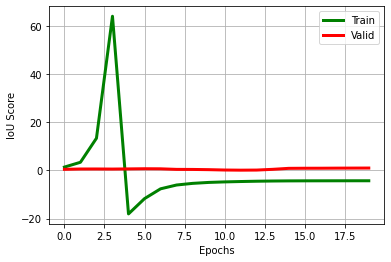

In [205]:
# Тут не дуже ясно чому iou score більше 1 та менше 0 може бути
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), "green", lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), "red", lw=3, label = 'Valid')

plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend(loc='best')
plt.grid()
plt.show()

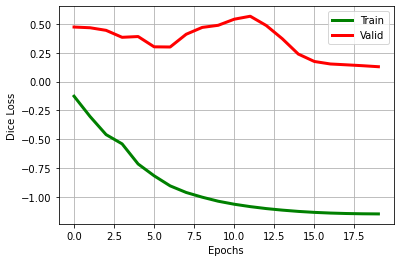

In [206]:
# plt.plot(train_logs_df.index.tolist(), train_logs_df.jaccard_loss.tolist(), "green", lw=3, label = 'Train')
# plt.plot(valid_logs_df.index.tolist(), valid_logs_df.jaccard_loss.tolist(), "red", lw=3, label = 'Valid')

plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), "green" , lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), "red" , lw=3, label = 'Valid')

plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.legend(loc='best')
plt.grid()
plt.show()

In [110]:
os.listdir("./")

['train_images',
 'test_images',
 'train_masks',
 'validation_masks',
 'test_masks',
 'best_model_test.pth',
 '__notebook_source__.ipynb',
 'validation_images']

In [207]:
# best_model = torch.load('./best_model.pth')
best_model = torch.load('./best_model_test.pth')

test_images_dir = "./test_images"
test_masks_dir = "./test_masks"
test_dataloader = DataLoader(SegmentationDataset(test_df, test_images_dir, test_masks_dir), batch_size=16, shuffle=False, num_workers=4)    

In [208]:
test_features, test_masks = next(iter(test_dataloader))

In [209]:
def visualize(images):
    names = ["Image", "True Mask", "Predicted Mask"]
    plt.figure(figsize=(16, 5))
    n = len(images)
    
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.title(names[i])
        image = images[i]
        
        if image.shape[0] == 3:
            image = image[0, :, :]
        plt.imshow(image)
    plt.show()

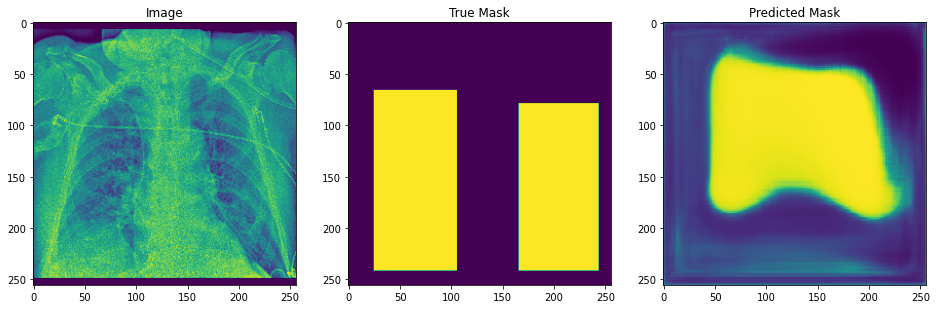

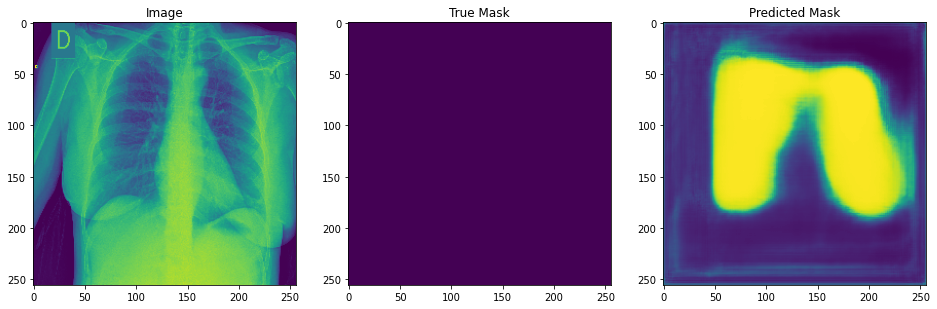

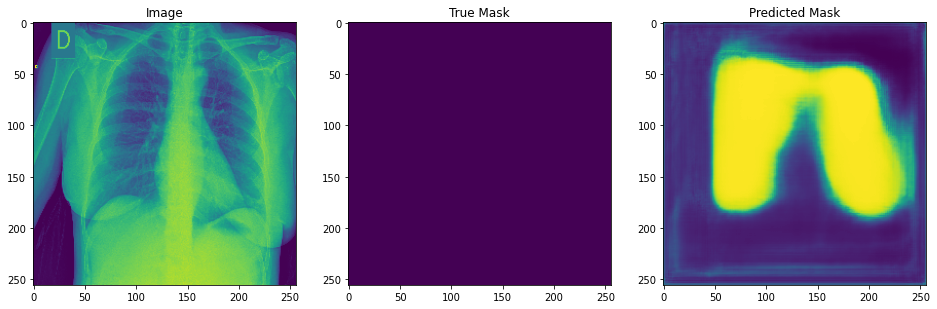

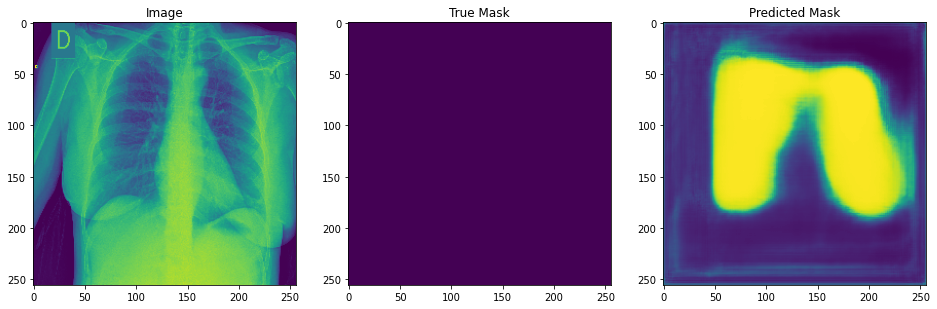

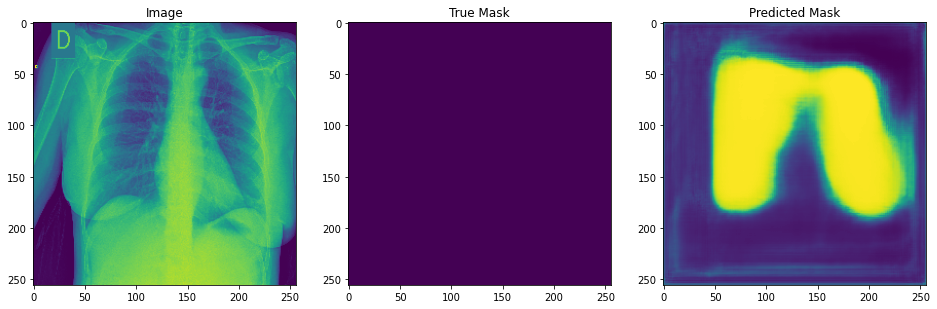

In [211]:
for i in range(5):
    index = np.random.choice(len(test_features))
    
    image_vis = test_features[index]
    mask_vis = test_masks[index]
    
    image_vis = np.array(image_vis).astype(np.float32)
    mask_vis = np.array(mask_vis).astype(np.float32)

    
    x_tensor = torch.from_numpy(image_vis).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = pr_mask.squeeze()
#     pr_mask = (pr_mask.squeeze().cpu().numpy() > 0.85)
#     mask_vis = mask_vis.squeeze()

    visualize([
        image_vis, 
        mask_vis, 
        pr_mask
    ])